In [1]:
%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
import pandas as pd
import os
import sys
import datetime

root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)
    
load_dotenv()

True

In [2]:
import tensorflow as tf
tf.__version__, tf.config.list_physical_devices('GPU')

('2.10.1', [])

In [3]:
from utils.utils import date_range, preprocess_b

df_train = pd.concat([
    pd.read_csv(f'../datasets/d{d.strftime("%Y-%m-%d")}.csv') for d in date_range(
        datetime.date(2019, 11, 1), 
        datetime.date(2020, 2, 1),
        datetime.timedelta(days=1),
    )
])
df_val = pd.concat([
    pd.read_csv(f'../datasets/d{d.strftime("%Y-%m-%d")}.csv') for d in date_range(
        datetime.date(2020, 2, 1), 
        datetime.date(2020, 2, 15),
        datetime.timedelta(days=1),
    )
])

X_train, y_train = preprocess_b(df_train)
X_val, y_val = preprocess_b(df_val)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1598125, 124), (1598125, 4), (263845, 124), (263845, 4))

In [4]:
from keras.models import Sequential, clone_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

prev_days = int(os.getenv('PREV_DAYS'))


model = Sequential()
model.add(InputLayer((4 + 4 * prev_days, 1)))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation=LeakyReLU(alpha=0.01)))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 122, 64)           256       
                                                                 
 flatten (Flatten)           (None, 7808)              0         
                                                                 
 dense (Dense)               (None, 8)                 62472     
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 62,737
Trainable params: 62,737
Non-trainable params: 0
_________________________________________________________________


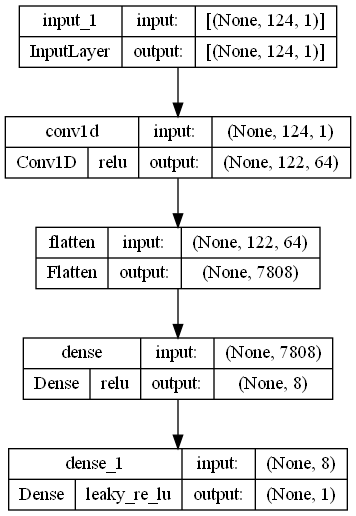

In [5]:
# plot model
from keras.utils import plot_model

plot_model(model,to_file='../.data/model_b.png', show_layer_activations=True, show_shapes=True, show_layer_names=True)

In [6]:
model_view = clone_model(model)
cp_view = ModelCheckpoint('../model/b-view.keras', save_best_only=True)
model_view.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model_view.fit(X_train, y_train[:, 0], validation_data=(X_val, y_val[:, 0]), epochs=3, callbacks=[cp_view])

Epoch 1/3
49942/49942 [==============================] - 153s 3ms/step - loss: 6.0460e-06 - root_mean_squared_error: 0.0025 - val_loss: 1.2079e-05 - val_root_mean_squared_error: 0.0035
Epoch 2/3
49942/49942 [==============================] - 172s 3ms/step - loss: 5.9651e-06 - root_mean_squared_error: 0.0024 - val_loss: 1.2101e-05 - val_root_mean_squared_error: 0.0035
Epoch 3/3
49942/49942 [==============================] - 162s 3ms/step - loss: 5.9652e-06 - root_mean_squared_error: 0.0024 - val_loss: 1.2079e-05 - val_root_mean_squared_error: 0.0035


In [7]:

model_cart = clone_model(model)
cp_cart = ModelCheckpoint('../model/b-cart.keras', save_best_only=True)
model_cart.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model_cart.fit(X_train, y_train[:, 1], validation_data=(X_val, y_val[:, 1]), epochs=3, callbacks=[cp_cart])

Epoch 1/3
49942/49942 [==============================] - 165s 3ms/step - loss: 1.9842e-05 - root_mean_squared_error: 0.0045 - val_loss: 1.0458e-05 - val_root_mean_squared_error: 0.0032
Epoch 2/3
49942/49942 [==============================] - 164s 3ms/step - loss: 9.5825e-06 - root_mean_squared_error: 0.0031 - val_loss: 1.0706e-05 - val_root_mean_squared_error: 0.0033
Epoch 3/3
49942/49942 [==============================] - 159s 3ms/step - loss: 8.8590e-06 - root_mean_squared_error: 0.0030 - val_loss: 1.0543e-05 - val_root_mean_squared_error: 0.0032


In [8]:

model_remove_from_cart = clone_model(model)
cp_remove_from_cart = ModelCheckpoint('../model/d-remove_from_cart.keras', save_best_only=True)
model_remove_from_cart.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model_remove_from_cart.fit(X_train, y_train[:, 2], validation_data=(X_val, y_val[:, 2]), epochs=3, callbacks=[cp_remove_from_cart])

Epoch 1/3
49942/49942 [==============================] - 203s 4ms/step - loss: 2.9744e-04 - root_mean_squared_error: 0.0172 - val_loss: 2.0575e-04 - val_root_mean_squared_error: 0.0143
Epoch 2/3
49942/49942 [==============================] - 191s 4ms/step - loss: 1.1644e-04 - root_mean_squared_error: 0.0108 - val_loss: 1.0233e-04 - val_root_mean_squared_error: 0.0101
Epoch 3/3
49942/49942 [==============================] - 216s 4ms/step - loss: 8.6748e-05 - root_mean_squared_error: 0.0093 - val_loss: 9.7305e-05 - val_root_mean_squared_error: 0.0099


In [9]:

model_purchase = clone_model(model)
cp_purchase = ModelCheckpoint('../model/b-purchase.keras', save_best_only=True)
model_purchase.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model_purchase.fit(X_train, y_train[:, 3], validation_data=(X_val, y_val[:, 3]), epochs=3, callbacks=[cp_purchase])

Epoch 1/3
49942/49942 [==============================] - 179s 4ms/step - loss: 8.3424e-05 - root_mean_squared_error: 0.0091 - val_loss: 5.7949e-05 - val_root_mean_squared_error: 0.0076
Epoch 2/3
49942/49942 [==============================] - 175s 4ms/step - loss: 8.3405e-05 - root_mean_squared_error: 0.0091 - val_loss: 5.7961e-05 - val_root_mean_squared_error: 0.0076
Epoch 3/3
49942/49942 [==============================] - 193s 4ms/step - loss: 8.3406e-05 - root_mean_squared_error: 0.0091 - val_loss: 5.8179e-05 - val_root_mean_squared_error: 0.0076
